<a href="https://colab.research.google.com/github/2667schummr/recurrent-nn-cystic-fibrosis/blob/modern-no-na/cf_rnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score
from google.colab import drive
from imblearn.over_sampling import RandomOverSampler
import matplotlib.pyplot as plt

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [0]:
# Specify training parameters
device = '/device:GPU:0'
print_every = 100
batch_size = 100

In [0]:
# Make google drive files accessible
drive.mount('/content/gdrive')
path = '/content/gdrive/My Drive/Colab Notebooks/modern-data-rnn'
os.chdir(path)
print('Current Working Directory: {}'.format(os.getcwd()))
from utils import *

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
Current Working Directory: /content/gdrive/My Drive/Colab Notebooks/modern-data-rnn


## Data Description  
This dataset consists of time steps that occurred no later than 2002.  Some of the physiological metrics did not exist before this period which disqualified them from the dataset in notebook 2 due to excessive missing values.  For a feature to be included, it had to have no more than 20% of its values missing and time steps with missing values were removed.

In [0]:
# Load the panda dataframe containing the features for the dataset in notebook 1
feats = pd.read_pickle('../cf-data/processed_data_complete_feats.pkl')
print('Feature Shape: {}'.format(feats.shape))

drop_cols = ['eDWID', 'YRM'] # These are identification columns
feats.head()

Feature Shape: (513452, 34)


,eDWID,YRM,mssa,mrsa,h_flu,pseudo,burkho_complex,alcalig,steno,enterobacter,serratia_marcescens,aspergillus,candida,scedosporium,mabscessus,mai,bd_age,sex,suff,trunc03,all_tob,all_mod,all_bd,dnase,inhcolistin,inhaztreonam,hypersaline,chronic_macrolide,oral_steroids,inh_steroids,inhsteroids_bronchodil,oral_other_abx,txflag,othertx
0,900000702,2003,0,0,0,1,0,0,0,0,0,1,0,0,0,0,6,0,0,1,1,0,0,1,0,0,0,1,0,0,0,0,0,0
1,900000702,2004,0,0,0,1,0,0,0,0,0,0,0,0,0,0,7,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0
2,900000702,2005,0,0,0,1,0,0,0,0,0,1,0,0,0,0,8,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0
3,900000702,2006,0,0,0,1,0,0,0,0,0,1,0,0,0,0,9,0,0,0,1,0,1,1,0,0,0,1,0,1,0,0,0,0
4,900000702,2007,0,0,0,1,0,0,0,0,0,1,0,0,0,0,10,0,0,0,1,0,1,1,0,0,0,1,0,1,0,0,0,0


In [0]:
# Construct the dataset consisting of observations no latter
# than 2002
data_train = pd.read_csv('../cf-data/modern_training_no_na.csv')
data_test = pd.read_csv('../cf-data/modern_testing_no_na.csv')
data_total = pd.concat([data_train, data_test], axis=0)
print('Feature Shape: {}'.format(data_total.shape))

Feature Shape: (959345, 56)


In [0]:
# Keep only the features from dataset 1
feats = data_total[feats.columns]
max_seq_length = feats.groupby('eDWID').count()['YRM'].max()
print(feats.shape)

(959345, 34)


In [0]:
# Extract the binary features
excluded_cols = ['dflag', 'dflag5']
for col in data_total.columns:
  num_unique = data_total[col].nunique()
  if col not in feats.columns and num_unique == 2 and col not in excluded_cols:
    feats[col] = data_total[col]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [0]:
# Add non-categorical features
cols = ['fev1pct_best', 'zscore_best', 'NumCult', 'nextNumCult']
for col in cols:
  feats[col] = data_total[col]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [0]:
# one-hot-encode trunc03 feature
feats = pd.get_dummies(feats, columns=['trunc03'])
num_feats = feats.shape[1] - 2
feats.head()

,eDWID,YRM,mssa,mrsa,h_flu,pseudo,burkho_complex,alcalig,steno,enterobacter,serratia_marcescens,aspergillus,candida,scedosporium,mabscessus,mai,bd_age,sex,suff,all_tob,all_mod,all_bd,dnase,inhcolistin,inhaztreonam,hypersaline,chronic_macrolide,oral_steroids,inh_steroids,inhsteroids_bronchodil,oral_other_abx,txflag,othertx,diabet,impglu,gainburkho_complex,gainalcalig,gainenterobacter,gainserratia_marcescens,gainscedosporium,gainmabscessus,gainmai,fev1pct_best,zscore_best,NumCult,nextNumCult,trunc03_0,trunc03_1,trunc03_2,trunc03_3,trunc03_4,trunc03_5
0,900000702,2003,0,0,0,1,0,0,0,0,0,1,0,0,0,0,6,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,135.283454,-0.673408,5,3,0,1,0,0,0,0
1,900000702,2003,0,0,0,1,0,0,0,0,0,1,0,0,0,0,6,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,135.283454,-0.673408,5,3,0,1,0,0,0,0
2,900000702,2003,0,0,0,1,0,0,0,0,0,1,0,0,0,0,6,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,135.283454,-0.673408,5,3,0,1,0,0,0,0
3,900000702,2003,0,0,0,1,0,0,0,0,0,1,0,0,0,0,6,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,135.283454,-0.673408,5,3,0,1,0,0,0,0
4,900000702,2003,0,0,0,1,0,0,0,0,0,1,0,0,0,0,6,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,135.283454,-0.673408,5,3,0,1,0,0,0,0


In [0]:
# Extract the patient labels
labels = data_total[['eDWID', 'dflag']].drop_duplicates()
print('Labels Shape: {}'.format(labels.shape))
num_obs = labels.shape[0]
labels.head()

Labels Shape: (28199, 2)


,eDWID,dflag
0,900000702,0
61,900000742,1
75,900010778,0
90,900020752,0
97,900030752,0


In [0]:
# Split the data into training and testing sets and create Dataset objects 
# and oversample training data for class balance
labels = labels.sample(frac=1)
labels_train, labels_test = train_test_split(labels, test_size=0.2, shuffle=False)

ros = RandomOverSampler()
X, y = ros.fit_resample(labels_train['eDWID'].as_matrix().reshape((-1, 1)), 
                        labels_train['dflag'])
labels_train = pd.DataFrame({'eDWID': X.reshape((-1,)), 'dflag': y})

patient_batches_train = Dataset(labels_train, batch_size, shuffle=True)
patient_batches_test = Dataset(labels_test, batch_size, shuffle=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """
/content/gdrive/My Drive/Colab Notebooks/modern-data-rnn/utils.py:12: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  self.X = labels['eDWID'].as_matrix()
/content/gdrive/My Drive/Colab Notebooks/modern-data-rnn/utils.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  self.y = labels['dflag'].as_matrix()


Means Deaths per Batch 0.5000635132876483



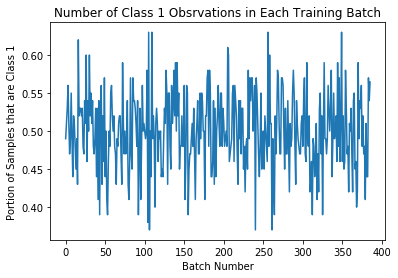

In [0]:
deaths_per_batch = []
batch_num = []
for i, (patients, patient_labels) in enumerate(patient_batches_train):
  deaths_per_batch.append(patient_labels.sum() / patient_labels.shape[0])
  batch_num.append(i)

plt.plot(batch_num, deaths_per_batch);
mean_deaths_per_batch = np.array(deaths_per_batch).mean()
print('Means Deaths per Batch {}\n'.format(mean_deaths_per_batch))
plt.title('Number of Class 1 Obsrvations in Each Training Batch');
plt.xlabel('Batch Number');
plt.ylabel('Portion of Samples that are Class 1');

In [0]:
one_class_freq_train = labels_train['dflag'].mean()
one_class_freq_test = labels_test['dflag'].mean()
print('1 Class Frequency for Training: {}'.format(one_class_freq_train))
print('1 Class Frequency for Test: {}'.format(one_class_freq_test))

1 Class Frequency for Training: 0.5
1 Class Frequency for Test: 0.14308510638297872


## Multi-Layer LSTM RNN plus a Fully Connected Network  
This is the same architecture used in notebook 2 except it is being trained on the modern data exclusively.

In [0]:
def model_init_fn(inputs, is_training, seq_filter):
    layers = [tf.keras.layers.LSTM(500,
                                   batch_input_shape=(None, max_seq_length, num_feats),
                                   return_sequences=True), 
              tf.keras.layers.LSTM(500, return_sequences=False),
              tf.keras.layers.Dense(500, activation='relu'),
              tf.keras.layers.Dense(2)]
    model = tf.keras.Sequential(layers)

    return model(inputs, mask=seq_filter, training=is_training) 

learning_rate = 1e-3
def optimizer_init_fn():
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    return optimizer

loss_history, perf_history, _ = train(model_init_fn, optimizer_init_fn, 
                                   max_seq_length, num_feats, patient_batches_train, 
                                   patient_batches_test, batch_size, 
                                   feats, drop_cols, labels, print_every, num_epochs=1)



Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where





Starting epoch 0


/content/gdrive/My Drive/Colab Notebooks/modern-data-rnn/utils.py:36: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  patient_feats = patient_feats.as_matrix()
/content/gdrive/My Drive/Colab Notebooks/modern-data-rnn/utils.py:41: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  Y[i] = labels[labels.eDWID == patient]['dflag'].as_matrix()[0]


Iteration 0, loss = 0.6816
Accuracy: Got 3972 / 5700 correct (69.68%)
Precision: Got 709 / 803.0 correct (88.29389788293898%)
True Negative Rate: Got 3263 / 4897.0 correct (66.63263222381049%)

Iteration 100, loss = 0.4606
Accuracy: Got 4721 / 5700 correct (82.82%)
Precision: Got 663 / 803.0 correct (82.56537982565379%)
True Negative Rate: Got 4058 / 4897.0 correct (82.8670614662038%)

Iteration 200, loss = 0.3407
Accuracy: Got 4712 / 5700 correct (82.67%)
Precision: Got 704 / 803.0 correct (87.67123287671232%)
True Negative Rate: Got 4008 / 4897.0 correct (81.84602818051869%)

Iteration 300, loss = 0.3349
Accuracy: Got 4795 / 5700 correct (84.12%)
Precision: Got 701 / 803.0 correct (87.29763387297635%)
True Negative Rate: Got 4094 / 4897.0 correct (83.60220543189708%)



## Performance Evaluation  
The convergence rate and performance on this dataset was similar to the full dataset from notebook 2 but the training time was significantly less.

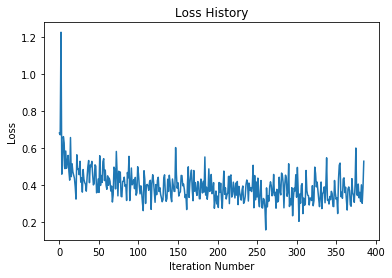

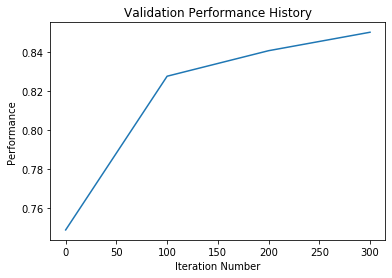

In [0]:
plt.figure()
plt.plot(range(len(loss_history)), loss_history);
plt.xlabel('Iteration Number');
plt.ylabel('Loss')
plt.title('Loss History');

plt.figure();
iterations = 100*np.array(range(len(perf_history)))
plt.plot(iterations, perf_history);
plt.title('Validation Performance History');
plt.xlabel('Iteration Number');
plt.ylabel('Performance');

## Learning Rate Tuning  
The following code tests varying learning rates with respect to network performance.  A learning rate of 0.001 produced the best performance on the validation dataset.

Current Learning Rate: 0.01
Starting epoch 0


/content/gdrive/My Drive/Colab Notebooks/modern-data-rnn/utils.py:36: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  patient_feats = patient_feats.as_matrix()
/content/gdrive/My Drive/Colab Notebooks/modern-data-rnn/utils.py:41: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  Y[i] = labels[labels.eDWID == patient]['dflag'].as_matrix()[0]


Iteration 0, loss = 0.7479
Accuracy: Got 803 / 5700 correct (14.09%)
Precision: Got 803 / 803.0 correct (100.0%)
True Negative Rate: Got 0 / 4897.0 correct (0.0%)

Iteration 100, loss = 0.5028
Accuracy: Got 4527 / 5700 correct (79.42%)
Precision: Got 674 / 803.0 correct (83.93524283935243%)
True Negative Rate: Got 3853 / 4897.0 correct (78.68082499489483%)

Iteration 200, loss = 0.4059
Accuracy: Got 4976 / 5700 correct (87.30%)
Precision: Got 564 / 803.0 correct (70.23661270236613%)
True Negative Rate: Got 4412 / 4897.0 correct (90.0959771288544%)

Iteration 300, loss = 0.3413
Accuracy: Got 4686 / 5700 correct (82.21%)
Precision: Got 691 / 803.0 correct (86.05230386052304%)
True Negative Rate: Got 3995 / 4897.0 correct (81.58055952624056%)

Current Learning Rate: 0.001
Starting epoch 0
Iteration 0, loss = 0.6851
Accuracy: Got 3832 / 5700 correct (67.23%)
Precision: Got 713 / 803.0 correct (88.7920298879203%)
True Negative Rate: Got 3119 / 4897.0 correct (63.69205636103737%)

Iteration 

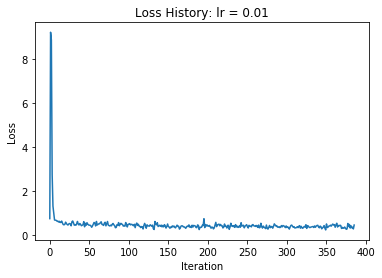

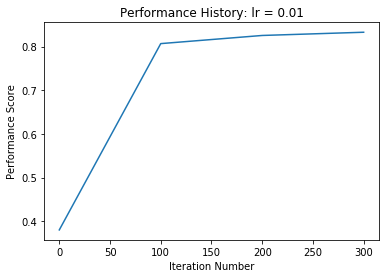

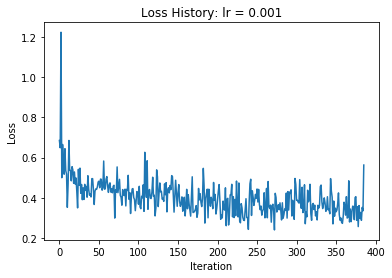

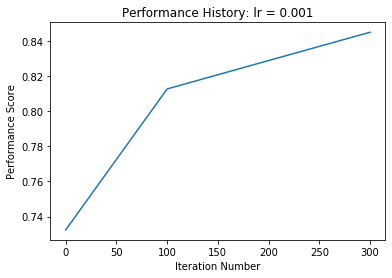

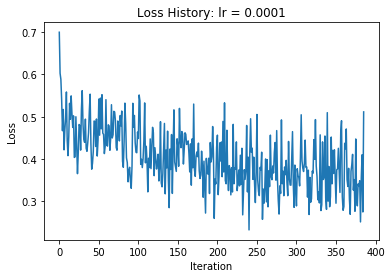

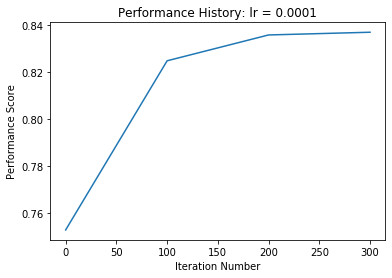

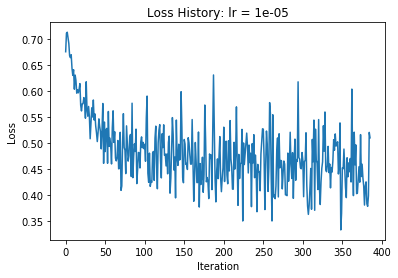

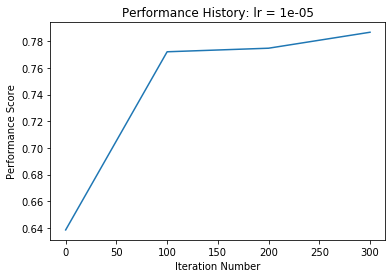

In [0]:
def plot_train_history(loss_history, perf_history, learning_rate):
  plt.figure()
  plt.plot(range(len(loss_history)), loss_history);
  plt.xlabel('Iteration');
  plt.ylabel('Loss');
  plt.title('Loss History: lr = {}'.format(learning_rate));

  plt.figure();
  plt.plot(np.array(range(len(perf_history)))*100, perf_history);
  plt.xlabel('Iteration Number');
  plt.ylabel('Performance Score');
  plt.title('Performance History: lr = {}'.format(learning_rate))

learning_rates = [1e-2, 1e-3, 1e-4, 1e-5]
perf = []
for learning_rate in learning_rates:
  print('Current Learning Rate: {}'.format(learning_rate))
  def model_init_fn(inputs, is_training, seq_filter):
      layers = [tf.keras.layers.LSTM(500,
                                    batch_input_shape=(None, max_seq_length, num_feats),
                                    return_sequences=True), 
                tf.keras.layers.LSTM(500, return_sequences=False),
                tf.keras.layers.Dense(500, activation='relu'),
                tf.keras.layers.Dense(2)]
      model = tf.keras.Sequential(layers)

      return model(inputs, mask=seq_filter, training=is_training) 

  def optimizer_init_fn():
      optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
      return optimizer

  loss_history, perf_history, _ = train(model_init_fn, optimizer_init_fn, 
                                        max_seq_length, num_feats, patient_batches_train, 
                                        patient_batches_test, batch_size, 
                                        feats, drop_cols, labels, print_every, num_epochs=1)

  plot_train_history(loss_history, perf_history, learning_rate)
  perf.append(np.max(perf_history))

Best Learning Rate: 0.001


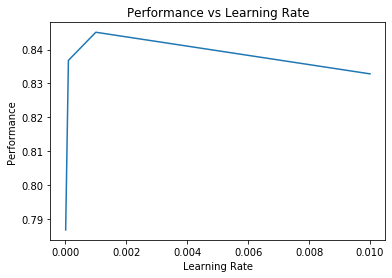

In [0]:
plt.figure();
plt.plot(learning_rates, perf);
plt.title('Performance vs Learning Rate');
plt.xlabel('Learning Rate');
plt.ylabel('Performance');

best_lr_index = np.argmax(perf)
best_lr = learning_rates[best_lr_index]
print('Best Learning Rate: {}'.format(best_lr))

## Final Model Training  
The model is now trained using the best performing learning rate and 5 epochs.  The testing data was split into a validation and testing set.  The validation set was used to compute performance metrics during training while the testing set is used for the final model evaluation.


In [0]:
# Split testing data into validation and final testing sets
labels_test_original = labels_test

labels_test = labels_test.sample(frac=1)
labels_val, labels_test = train_test_split(labels_test, test_size=0.5, shuffle=False)

patient_batches_val = Dataset(labels_val, batch_size, shuffle=True)
patient_batches_test = Dataset(labels_test, batch_size, shuffle=True)

/content/gdrive/My Drive/Colab Notebooks/modern-data-rnn/utils.py:12: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  self.X = labels['eDWID'].as_matrix()
/content/gdrive/My Drive/Colab Notebooks/modern-data-rnn/utils.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  self.y = labels['dflag'].as_matrix()


In [0]:
def model_init_fn(inputs, is_training, seq_filter):
    layers = [tf.keras.layers.LSTM(500,
                                   batch_input_shape=(None, max_seq_length, num_feats),
                                   return_sequences=True), 
              tf.keras.layers.LSTM(500, return_sequences=False),
              tf.keras.layers.Dense(500, activation='relu'),
              tf.keras.layers.Dense(2)]
    model = tf.keras.Sequential(layers)

    return model(inputs, mask=seq_filter, training=is_training) 

learning_rate = 1e-3
def optimizer_init_fn():
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    return optimizer

loss_history, perf_history, final_metrics = train(model_init_fn, optimizer_init_fn, 
                                                  max_seq_length, num_feats, patient_batches_train, 
                                                  patient_batches_val, batch_size, 
                                                  feats, drop_cols, labels, print_every, num_epochs=5,
                                                  patient_batches_test_final=patient_batches_test)

Starting epoch 0


/content/gdrive/My Drive/Colab Notebooks/modern-data-rnn/utils.py:36: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  patient_feats = patient_feats.as_matrix()
/content/gdrive/My Drive/Colab Notebooks/modern-data-rnn/utils.py:41: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  Y[i] = labels[labels.eDWID == patient]['dflag'].as_matrix()[0]


Iteration 0, loss = 0.7351
Accuracy: Got 2319 / 2900 correct (79.97%)
Precision: Got 234 / 403.0 correct (58.06451612903226%)
True Negative Rate: Got 2085 / 2497.0 correct (83.50020024028835%)

Iteration 100, loss = 0.4223
Accuracy: Got 2308 / 2900 correct (79.59%)
Precision: Got 343 / 403.0 correct (85.11166253101737%)
True Negative Rate: Got 1965 / 2497.0 correct (78.69443331998399%)

Iteration 200, loss = 0.4436
Accuracy: Got 2418 / 2900 correct (83.38%)
Precision: Got 343 / 403.0 correct (85.11166253101737%)
True Negative Rate: Got 2075 / 2497.0 correct (83.09971966359632%)

Iteration 300, loss = 0.3374
Accuracy: Got 2482 / 2900 correct (85.59%)
Precision: Got 335 / 403.0 correct (83.12655086848635%)
True Negative Rate: Got 2147 / 2497.0 correct (85.98317981577893%)

Starting epoch 1
Iteration 400, loss = 0.2949
Accuracy: Got 2497 / 2900 correct (86.10%)
Precision: Got 325 / 403.0 correct (80.64516129032258%)
True Negative Rate: Got 2172 / 2497.0 correct (86.98438125750901%)

Itera

## Training-Time Loss and Performance on Validation Data

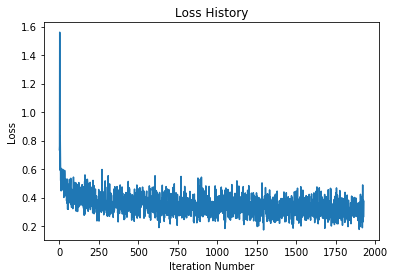

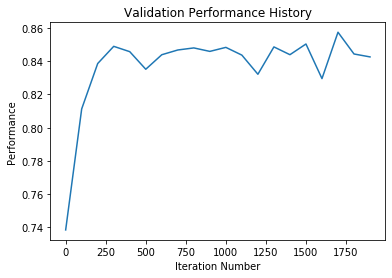

In [0]:
plt.figure()
plt.plot(range(len(loss_history)), loss_history);
plt.xlabel('Iteration Number');
plt.ylabel('Loss')
plt.title('Loss History');

plt.figure();
iterations = 100*np.array(range(len(perf_history)))
plt.plot(iterations, perf_history);
plt.title('Validation Performance History');
plt.xlabel('Iteration Number');
plt.ylabel('Performance');

## Final Model Evaluation on Testing Data
The network's final test performance was 85% accuracy.  The network predicted class 1 observations at a 5% higher rate than class 0 observations. 

In [0]:
print('Final Performance Metrics:')
print('\tAccuracy: {}'.format(100*final_metrics[0]))
print('\tTrue Positive Rate: {}%'.format(100*final_metrics[1]))
print('\tTrue Negative Rate: {}%'.format(100*final_metrics[2]))

Final Performance Metrics:
	Accuracy: 85.20689655172414
	True Positive Rate: 89.60396039603961%
	True Negative Rate: 84.4951923076923%
